<h1><center>DSO 599 - Final Project</center></h1>
<h2><center>Deep Learning Applications on SPX Volatility Forecasting</center></h2>
<h3><center>Francis Chen</center></h3>

## Abstract

Within the financial markets, volatility plays a crucial role in many areas, such as portfolio construction, derivatives pricing, risk management, and hedging strategies. Accurately predicting volatility can be vital for an asset manager and could lead to large advantages in the investment space. Modeling volatility has been extensively researched and familiar models, such as GARCH, EGARCH, and variations of the two, have been used in countless papers. However, while most financial data exhibit non-linear characteristics, the classic models generally assume a linear structure. With the explosion in computing power, Deep Learning methods, such as Artificial Neural Networks (ANNs), can now be utilized freely. Their flexibility to approximate any nonlinear function arbitrarily without prior assumptions on the data distribution make Neural Networks invaluable in predicting volatility. This paper will explore applications of a Simple Multilayer Perceptron (MLP) model, as well as a Recurrent Neural Network on forecasting the well-known CBOE VIX Index.

## 1. Introduction

The CBOE Volatility Index, known by its ticker symbol VIX, is the most popular measure of the stock market's future (next 30 calendar days) expected volatility implied by the S&P 500 Index options chain. It is calculated and disseminated on a real-time basis by the Chicago Board Options Exchange (CBOE). This paper seeks to model the expected implied volatility (IV) of the market rather than the future realized volatility (RV) because most derivatives are priced using IV. Thus, the ability to accurately predict future implied volatility provides much more value to the asset manager. Note that only small code blocks will be displayed throughout this paper; the entire code can be found in the appendex.

## 2. Data Collection and Feature Engineering

Historical daily data of the CBOE VIX Index was collected from the official CBOE website with a date range from January 2, 1990 to date. Historical daily data with the same date range was also collected for the S&P 500 Index from Yahoo Finance. Only the daily closing values of these indices are used for the Deep Learning models. 

Additional custom features were then calculated using the S&P 500 daily closing prices to provide further information to the neural networks. These specific custom features are very common technical indicators within the investment landscape, and the reasoning behind them is beyond the scope of this paper.
- **Annualized Realized Volatility of the S&P 500 Index**: $RV = \sqrt{\frac{252}{n}\displaystyle\sum_{i=1}^{n} r_i^2}$
    * Where $r_i^2$ is the square of the daily log return of the S&P 500 Index for the $i^{th}$ trading day in the rolling window period. This is because returns are assumed to be centered at 0.
- **Simple Return of the S&P 500 Index for $n$ trading days**: $R_n = \frac{p_n}{p_1} - 1$
    * Where $p_i$ is the closing price of the S&P 500 Index for the $i^{th}$ trading day in the rolling window period.
- **Simple Short Moving Average vs Long Moving Average**: $SMA = \Big(\frac{1}{s}\displaystyle\sum_{k-s}^{k} p_i \Big/\frac{1}{k}\displaystyle\sum_{1}^{k} p_i\Big) - 1$ where $k > s$
    * In this paper, $s = 20 \text{, } k = 200$. Essentially, this how much larger or smaller the short term moving average in comparison to the long term moving average up to time $t$.
- **Maximum Drawdown of the Period**: This is simply the minimum return from peak to trough of the S&P 500 Index closing prices for the $n$ period rolling window. To avoid confusion no formal mathematical formulation will be written; please refer to the code in the appendex for calculation specifics.

Note that $n$ is the number of trading days in the rolling period window, which will be assumed to be 20 trading days for all custom features in order to be consistent with the monthly view of the CBOE VIX Index. The VIX is divided by 100 in the data set given that it is a measure of return volatility and this is actually represented as a percent by CBOE.

Finally, the data is cleaned by removing any null values. A sample of the first 5 rows is as follows:

VIX     RV  Return_20D  ShortVLongSMA  Max_DD_Period
1990-10-15 0.3164 0.2285     -0.0458        -0.0903        -0.0726
1990-10-16 0.3145 0.2339     -0.0618        -0.0924        -0.0726
1990-10-17 0.3137 0.2328     -0.0563        -0.0942        -0.0726
1990-10-18 0.2960 0.2400     -0.0184        -0.0944        -0.0726
1990-10-19 0.2786 0.2521      0.0037        -0.0937        -0.0726

Also, some statistical summaries for the features are found in the following table:

VIX         RV  Return_20D  ShortVLongSMA  Max_DD_Period
count 7,185.0000 7,185.0000  7,185.0000     7,185.0000     7,185.0000
mean      0.1915     0.1507      0.0071         0.0275        -0.0464
std       0.0783     0.0909      0.0421         0.0698         0.0391
min       0.0914     0.0338     -0.2816        -0.2962        -0.2835
25%       0.1350     0.0935     -0.0140        -0.0008        -0.0586
50%       0.1715     0.1271      0.0110         0.0368        -0.0365
75%       0.2254     0.1813      0.0309         0.0711        -0.0204
max       0.8086     0.8430      0.2349         0.1701        -0.0029

A clearer visualization of the features for forecasting implied volatility is below:

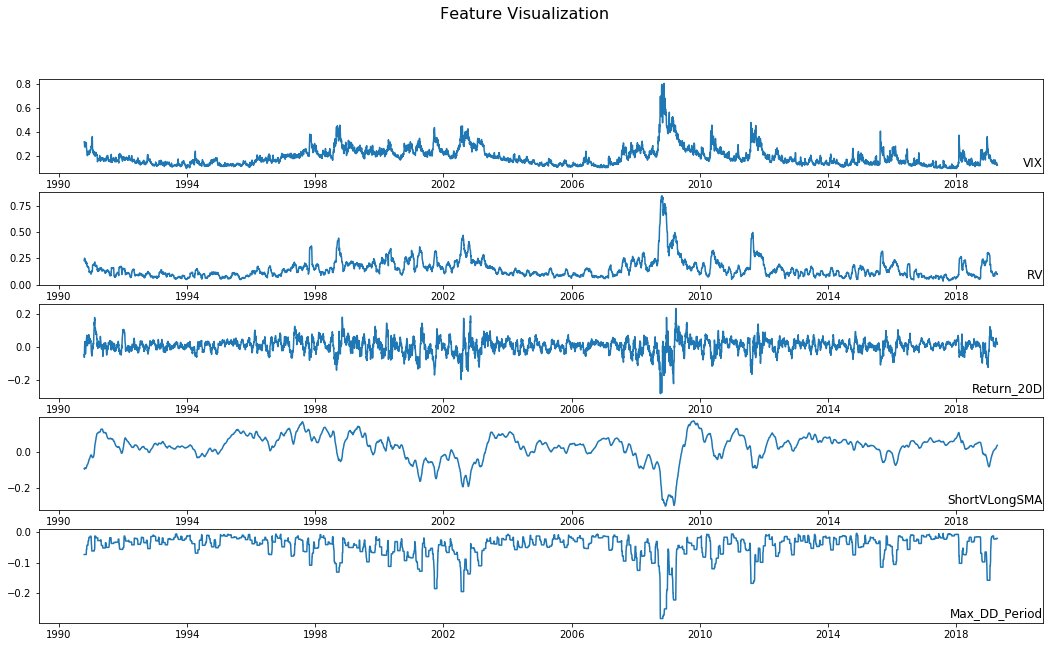

## 3. Data Preprocessing

After collecting and aggregating the data, it must then be split into training, validation, and test sets. The raw time-series data must also be converted to allow for supervised learning. For the learning methods, 60% of the data was used for training, 30% was used for validation, and 10% was used for testing. This was purposely done so that the training data will exclude the 2008 recession but still be exposed to the 2000 dot com crash. Thus, the neural networks can be trained to capture the stylized characteristics of financial returns such as leptokurtosis, volatility clustering, and leverage effects. A visualization of the data splits can be seen below, where blue is the training set, orange is the validation set, and green is the test set.

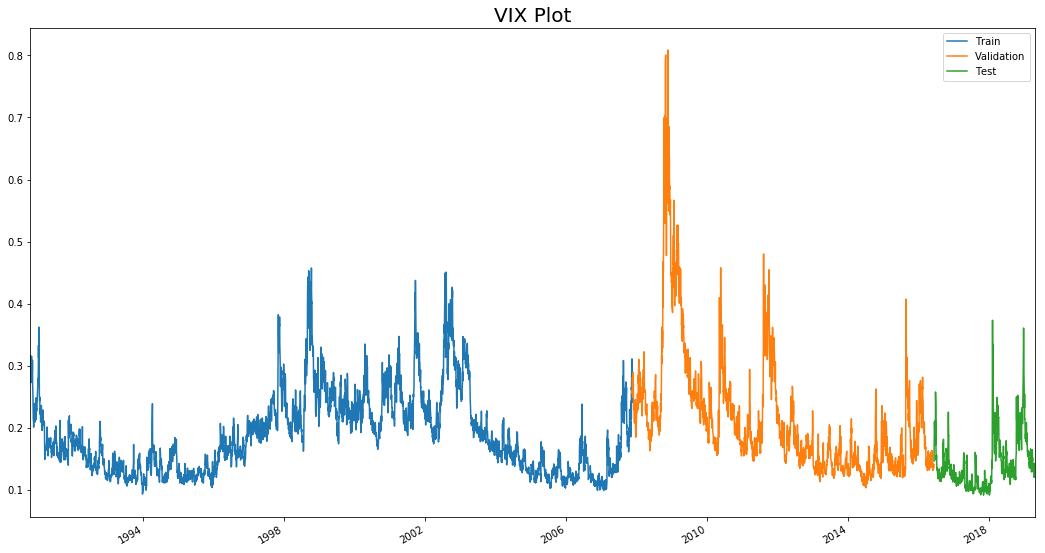

## 4. Modeling

##### 4.1 Simple MLP

First, a simple MLP is used in order to create a forecasting model. The neural network used in this situation has three hidden layers with the first layer having 9 nodes, the second layer having 6 nodes, and the third layer having 3 nodes. The Rectified Linear Units (ReLu) function was chosen as activations for both these hidden layers. The final output layer uses a linear activation function given that the problem is a regression problem. The batch size used was 200 and the number of epochs was 100. Mean Squared Error was used as the loss function given that this is a regression problem and Adam was used as the optimization algorithm. It should be noted that no normalization on the data was necessary given that every feature's range was between -1 and 1:
- $RV\in[0,1]$
- $VIX\in[0,1]$
- $MaxDD\in[-1,0]$
- Although $R_n\in[-1,\infty)$ and $ShortVLongSMA\in[-1,\frac{k-s}{s}]$, the data shows that these features are empirically less than 1.
    - The proof for the range of $ShortVLongSMA$ is a bit involved and can be found in the appendex.

The goal, specifically, is to predict the VIX Index value for the following day, i.e., predictiving $VIX_{t+1}$ given data up to $t$. The code for the construction and training of the model is as follows:

Training Set Shapes:  (4310, 5) (4310,)
Validation Set Shapes:  (2155, 5) (2155,)
Test Set Shapes:  (719, 5) (719,)


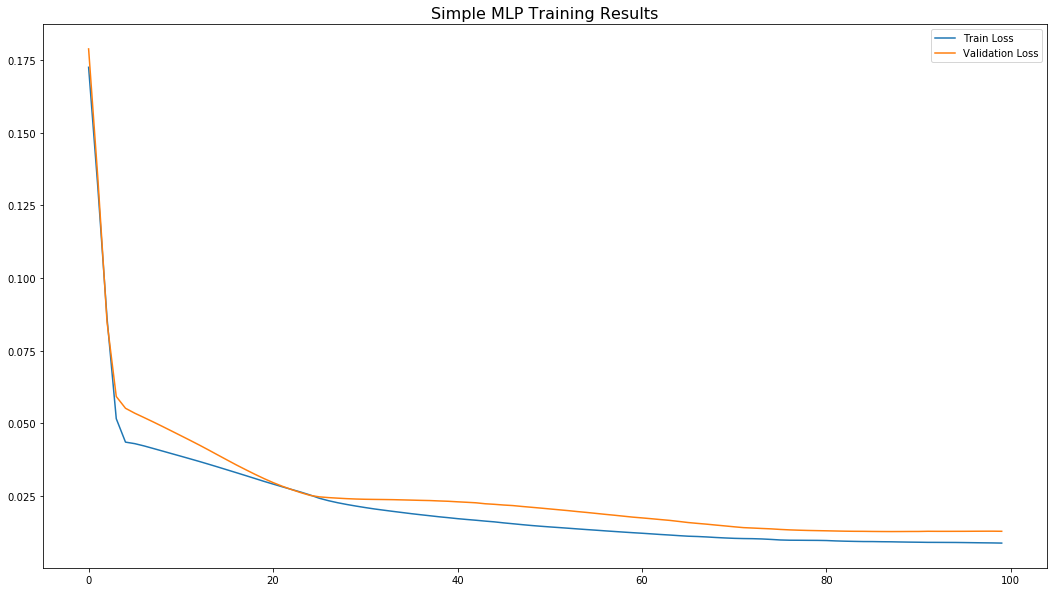

In [168]:
### Splitting Data into Training, Validation, and Test sets ###
train, validation, test = time_series_to_supervised_learning(data)

### Splitting into input and outputs ###
train_x, train_y, validation_x, validation_y, test_x, test_y = dataset_tensors(train, validation, test, 
                                                                               rnn = False, normalize = False)

### Designing Network ###
n_epochs = 100
batchsize = 200
model_mlp = keras.models.Sequential()
model_mlp.add(keras.layers.Dense(9, input_dim = train_x.shape[1], activation = 'relu'))
model_mlp.add(keras.layers.Dense(6, activation = 'relu'))
model_mlp.add(keras.layers.Dense(3, activation = 'relu'))
model_mlp.add(keras.layers.Dense(1))
model_mlp.compile(loss = 'mse', optimizer = 'adam')

### Creating Checkpointer ###
checkpointer_mlp = keras.callbacks.ModelCheckpoint(filepath = "MLP_mse_weights.hdf5", 
                                                   verbose = 0, 
                                                   save_best_only = True)

### Training Model ###
history_mlp = model_mlp.fit(train_x, train_y, epochs = n_epochs, 
                            batch_size = batchsize, 
                            validation_data = (validation_x, validation_y), 
                            verbose = 0, shuffle = False, 
                            callbacks = [checkpointer_mlp])

### Plotting Loss History ###
pyplot.figure(figsize = (18, 10))
pyplot.plot(history.history['loss'], label = 'Train Loss')
pyplot.plot(history.history['val_loss'], label = 'Validation Loss')
pyplot.title('Simple MLP Training Results', size = 16)
pyplot.legend()
pyplot.show()

The above graph shows the Training and Validation losses for each epoch. Next we evaluate the model on both the validation and test sets. Root Mean Squared Error (RMSE) was used as the evaluation metric for the model performance. The RMSE values and a plot of the predicted values against the actual values for the VIX Index are found below.

Validation RMSE: 0.026
Test RMSE: 0.015


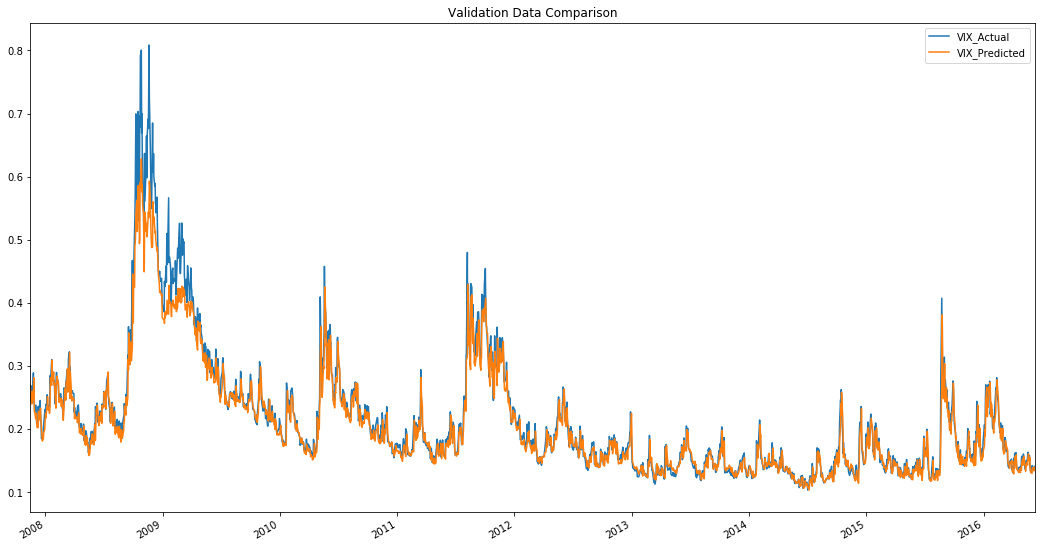

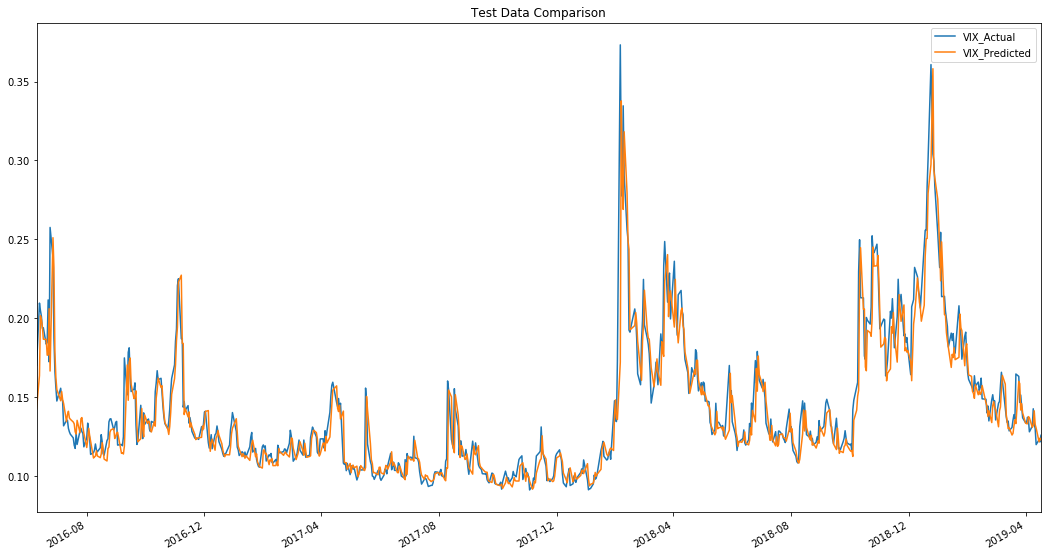

In [169]:
mlp_val, mlp_test = model_evaluation(model_mlp, validation, test, validation_x, validation_y, test_x, test_y, rnn = False)

The simple MLP model performs well on both the validation and test sets with RMSEs of 0.025 and 0.015, respectively. It's interesting to note that the test set's RMSE is actually lower than the validation set's. This can probably be explained by the fact that the validation set included the 2008 financial crisis, and thus had more frequent elevated VIX levels that needed to be accounted for. Nonetheless, the MLP model was able to account for these spikes better than standard GARCH models. Next, this paper explores an RNN approach using the same data sets.

##### 4.2 LSTM

Now, the Long Short-Term Memory (LSTM) RNN model is applied to create a forecasting model. The model is constructed using 30 neurons in the LSTM layer with the ReLu function chosen as the activation again. Since this remains a regression problem, the final output layer is still a linear activation function. The batch size was held at 200 and the number of epochs has also remained at 100. Rather than Mean Squared Error, Mean Absolute Error was chosen as the loss function. The optimization algorithm used remains as Adam. Similar to the simple MLP, no normalization on the data was necessary.

The code for the construction and training of the model is as follows:

Training Set Shapes:  (4310, 1, 5) (4310,)
Validation Set Shapes:  (2155, 1, 5) (2155,)
Test Set Shapes:  (719, 1, 5) (719,)


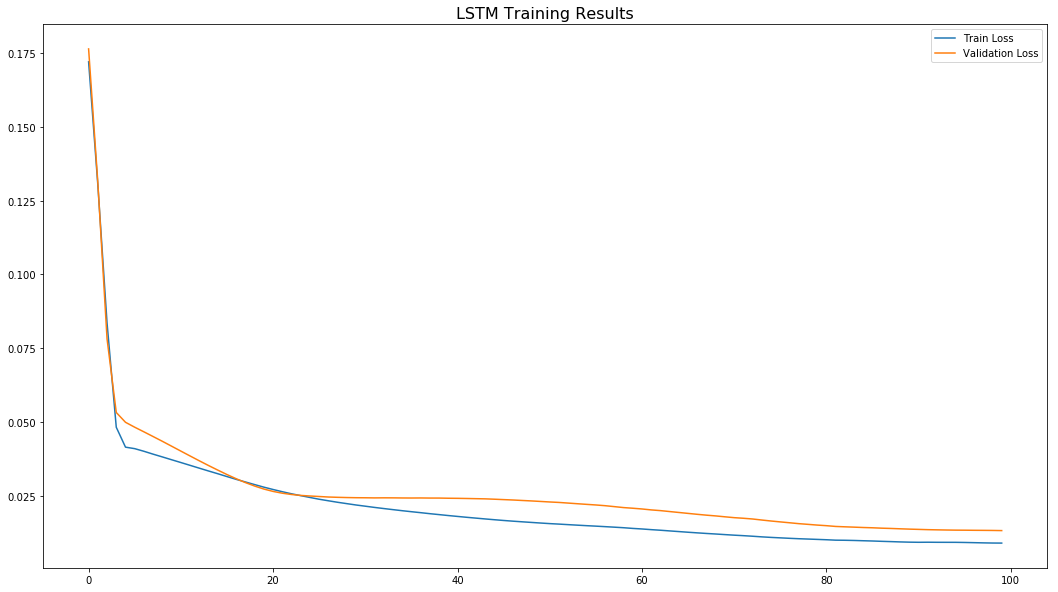

In [174]:
### Splitting Data into Training, Validation, and Test sets ###
train, validation, test = time_series_to_supervised_learning(data)

### Splitting into input and outputs ###

# RNN requires reshaping the data to be 3D [samples, timesteps, features] 
# for tensor operations, where timesteps in this case is 1

train_x, train_y, validation_x, validation_y, test_x, test_y = dataset_tensors(train, validation, test, 
                                                                               rnn = True, normalize = False)

### Designing Network ###
neurons = 30
n_epochs = 100
batchsize = 200
model = keras.models.Sequential()
model.add(keras.layers.LSTM(neurons, input_shape = (train_x.shape[1], train_x.shape[2]), activation = 'relu'))
model.add(keras.layers.Dense(1))
model.compile(loss = 'mean_absolute_error', optimizer = 'adam')

### Creating Checkpointer ###
checkpointer = keras.callbacks.ModelCheckpoint(filepath = "LSTM_mae_weights.hdf5", 
                                               verbose = 0, 
                                               save_best_only = True)

### Training Model ###
history = model.fit(train_x, train_y, epochs = n_epochs, 
                    batch_size = batchsize, 
                    validation_data = (validation_x, validation_y), 
                    verbose = 0, 
                    shuffle = False, callbacks = [checkpointer])

### Plotting Loss History ###
pyplot.figure(figsize = (18, 10))
pyplot.plot(history.history['loss'], label = 'Train Loss')
pyplot.plot(history.history['val_loss'], label = 'Validation Loss')
pyplot.title('LSTM Training Results', size = 16)
pyplot.legend()
pyplot.show()

The above graph shows the Training and Validation losses for each epoch. Next we evaluate the model on both the validation and test sets. Root Mean Squared Error (RMSE) was used as the evaluation metric for the model performance. The RMSE values and a plot of the predicted values against the actual values for the VIX Index are found below.

Validation RMSE: 0.025
Test RMSE: 0.016


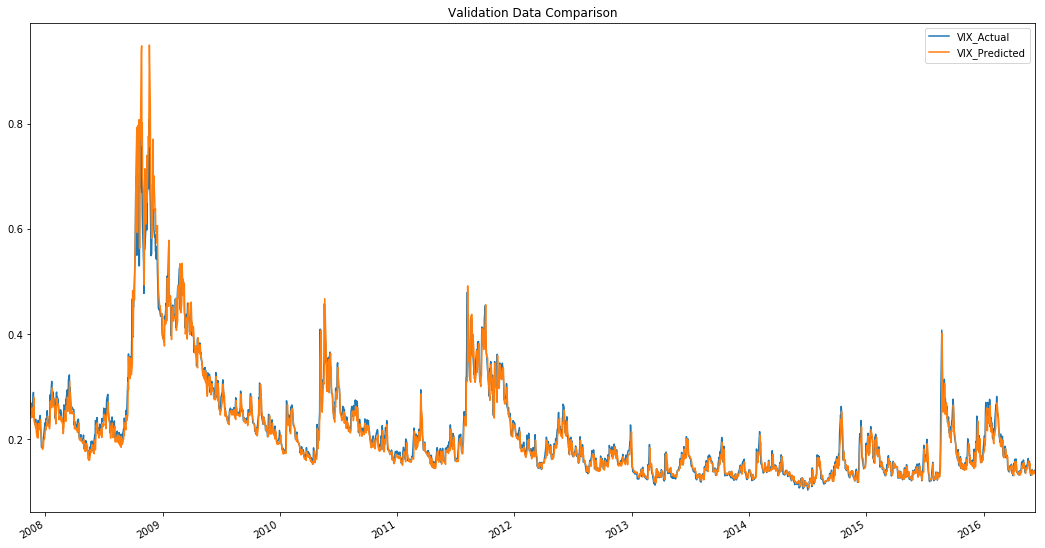

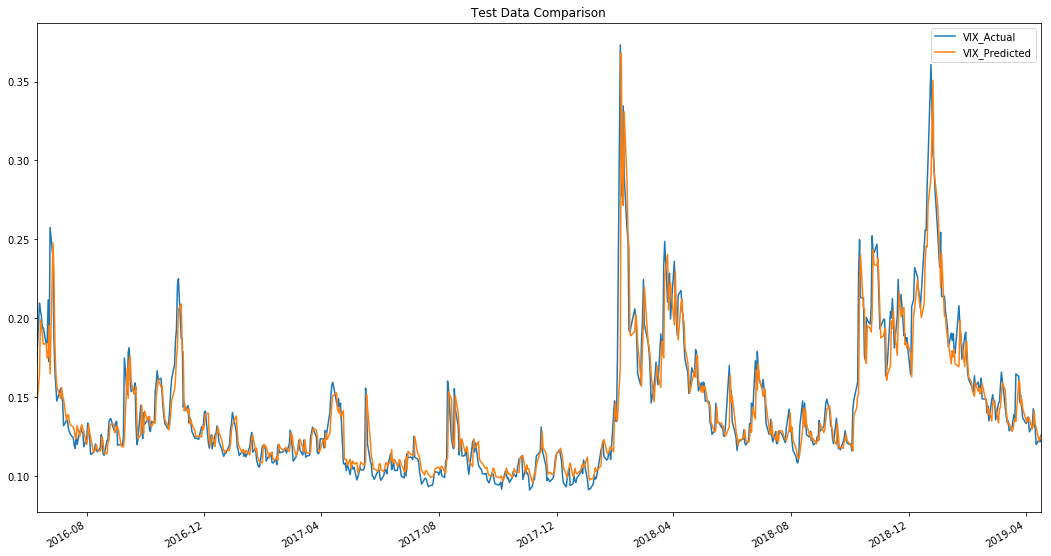

In [175]:
lstm_val, lstm_test = model_evaluation(model, validation, test, validation_x, validation_y, test_x, test_y, rnn = True)

The LSTM RNN model's performance is similar to the simple MLP's, with the LSTM performing slightly better on the validation set and slightly worse on the test set. However, it's worth noting that the LSTM model much more accurately captured the extreme VIX values during the 2008 financial crisis. This characteristic may be from the fact that the LSTM model is better at capturing the right-skew of the VIX and would be more accurate in higher volatility regimes in the market.

## 5. Conclusions


In this paper, the applications of Deep Learning methods, specifically a simple MLP and a LSTM RNN, were explored on forecasting the future expected implied volatility of the S&P 500, the CBOE VIX Index. Predictions were made for one trading day out or a timestep of one. These two models both performed well and were able to capture the non-linear nature of the financial data. However, the results from the previous section indicate that a LSTM RNN model is much better at capturing high volatility regimes. A comparison of the two model's predictions vs actuals for the 2008 financial crisis clearly shows this:

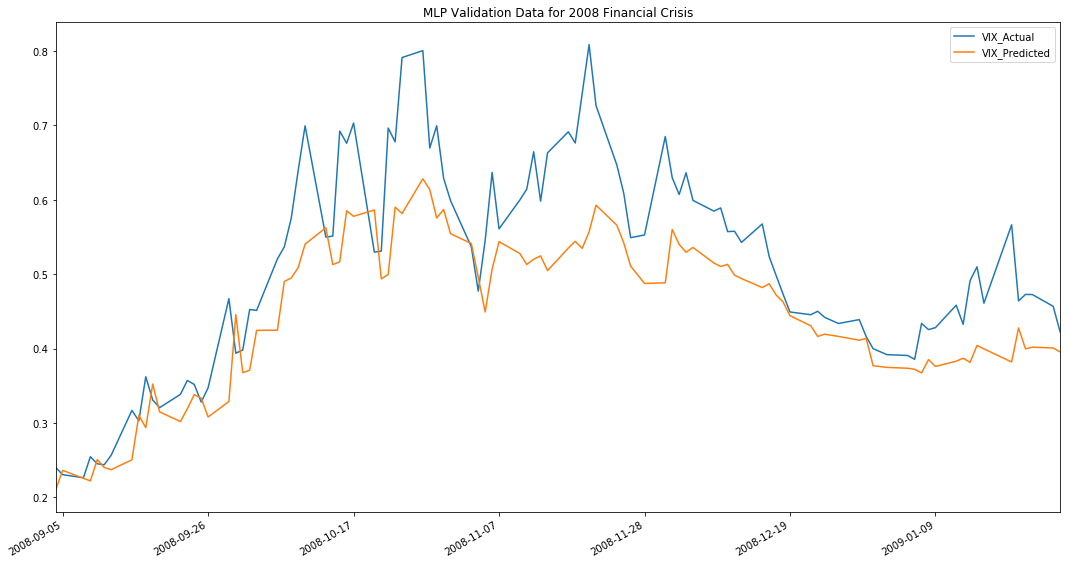

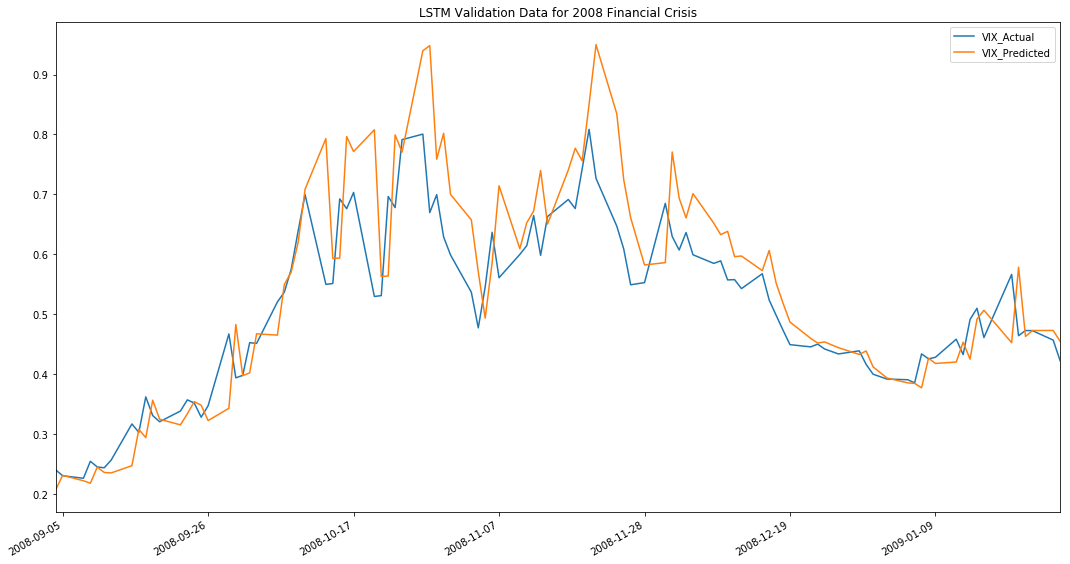

In [185]:
mlp_val.head(300).tail(100).plot(figsize = (18,10), title = 'MLP Validation Data for 2008 Financial Crisis')
pyplot.show()
lstm_val.head(300).tail(100).plot(figsize = (18,10), title = 'LSTM Validation Data for 2008 Financial Crisis')

In conclusion, further research can be explored in developing even more accurate volatility forecasting models using Deep Learning methods. Possible hybrid models using both classical GARCH or EGARCH and Neural Networks may yield better results. Another potential investigation would be to explore prediction accuracy of market volatility further out into the future, e.g., timesteps greater than one trading day.

## 6. References
- https://www.datacamp.com/community/tutorials/lstm-python-stock-market
- https://codeburst.io/neural-networks-for-algorithmic-trading-volatility-forecasting-and-custom-loss-functions-c030e316ea7e
- https://medium.com/@alexrachnog/neural-networks-for-algorithmic-trading-part-one-simple-time-series-forecasting-f992daa1045a
- https://towardsdatascience.com/an-introduction-on-time-series-forecasting-with-simple-neura-networks-lstm-f788390915b
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://github.com/guillaume-chevalier/seq2seq-signal-prediction
- https://gist.github.com/lukovkin/1aefa4509e066690b892
- https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679

## 7. Appendex

Proof that $ShortVLongSMA\in[-1,\frac{k-s}{s}]$,

$$
\begin{align}
SMA &= \Big(\frac{1}{s}\displaystyle\sum_{k-s}^{k} p_i \Big/\frac{1}{k}\displaystyle\sum_{1}^{k} p_i\Big) - 1 \\
&= \frac{k}{s}\Big(\displaystyle\sum_{k-s}^{k} p_i\Big/\displaystyle\sum_{1}^{k} p_i\Big) - 1 && \text{Where } k > s
\end{align}
$$
Let $\displaystyle\sum_{k-s}^{k} p_i = \alpha$, and we know that,
$$
\begin{align}
\displaystyle\sum_{1}^{k} p_i &= p_1 + p_2 + \cdots + p_{k-s} + p_{k-s+1} + \cdots + p_{k-1} + p_k\\
& = p_1 + p_2 + \cdots + p_{k-s-1} + \displaystyle\sum_{k-s}^{k} p_i \\
& = \displaystyle\sum_{1}^{k-s-1} p_i + \alpha \\
& = \beta + \alpha &&\text{where }  \beta = \displaystyle\sum_{1}^{k-s-1} p_i
\end{align}
$$
Then,
$$
\begin{align}
SMA &= \frac{k\alpha}{s(\alpha + \beta)} - 1 &&\text{where }  \alpha\in[0,\infty) \text{and} \beta\in[0,\infty)
\end{align}
$$

Thus, if we assume we either hold $\alpha$ or $\beta$ constant while taking the other to their limit and holding $k$ and $s$ constant,

$$
\begin{align}
&\lim\limits_{\alpha \to 0} ShortVLongSMA = \lim\limits_{\alpha \to 0} \frac{k\alpha}{s(\alpha + \beta)} - 1 = -1 \\
&\lim\limits_{\alpha \to \infty} ShortVLongSMA = \lim\limits_{\alpha \to \infty}\frac{k\alpha}{s(\alpha + \beta)} - 1 = \frac{k-s}{s} \\
&\lim\limits_{\beta \to 0} ShortVLongSMA = \lim\limits_{\beta \to 0}\frac{k\alpha}{s(\alpha + \beta)} - 1 = \frac{k-s}{s} \\
&\lim\limits_{\beta \to \infty} ShortVLongSMA = \lim\limits_{\beta \to \infty}\frac{k\alpha}{s(\alpha + \beta)} - 1 = -1 
\end{align}
$$

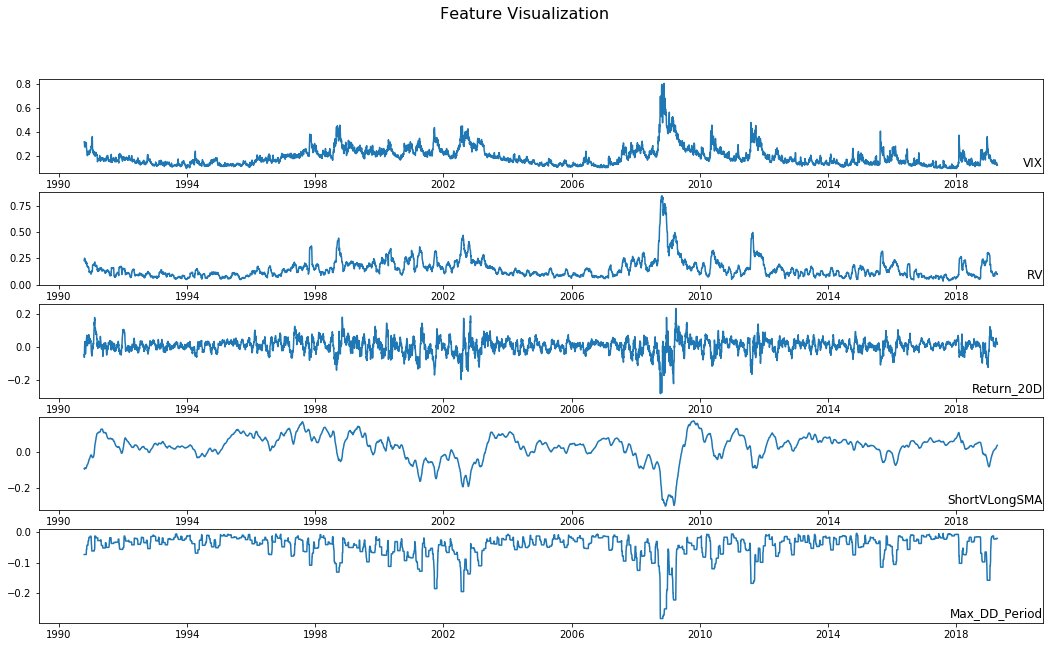

In [157]:
############################################# Importing modules #############################################

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import urllib.request as urlreq
import json
import os
import tensorflow.keras as keras
#os.chdir('.\ModelWeights')

from matplotlib import pyplot
pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

############################################# Data Collection #############################################

### Collecting VIX and SPX index data from CBOE and Yahoo Finance

# VIX Data Collection
curr_vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', 
                       skiprows = 1, index_col = 0)
curr_vix.index = pd.to_datetime(curr_vix.index)

hist_vix = pd.read_excel('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixarchive.xls',
                         skiprows = 1, index_col = 0)
hist_vix.index = pd.to_datetime(hist_vix.index)

vix = pd.concat([hist_vix,curr_vix], axis = 0)

# SPX Data Collection
ticker = '^GSPC'
start_date = dt.datetime(1990,1,1)
end_date = end_date = dt.datetime.today()

start_date_unix = int(start_date.timestamp())
end_date_unix = int(end_date.timestamp())

hist_price_url = 'https://query1.finance.yahoo.com/v8/finance/chart/{0}?symbol={0}&period1={1}&period2={2}&interval=1d'.format(ticker,start_date_unix,end_date_unix)

with urlreq.urlopen(hist_price_url) as url:
    data = json.loads(url.read().decode())
    hist_prices = pd.DataFrame({**data['chart']['result'][0]['indicators']['quote'][0], **data['chart']['result'][0]['indicators']['adjclose'][0]},
                               index = [dt.datetime.utcfromtimestamp(int(x)).date() for x in data['chart']['result'][0]['timestamp']])
    hist_prices.index = pd.to_datetime(hist_prices.index)
    hist_prices.columns = ["{0}_{1}".format(ticker.replace('^',''), x) for x in hist_prices.columns]

# Joining both VIX and SPX data into one dataframe and backfilling null values
data = pd.concat([hist_prices[['GSPC_close']], vix[['VIX Close']]], 
                 axis = 1).replace('n/a',np.nan).apply(lambda x: pd.to_numeric(x)).fillna(method = 'ffill')
data.columns = [col.replace('VIX Close','VIX') for col in data.columns.tolist()]

# Dividing VIX_Close by 100 given the index is a measure of implied future volatility
data['VIX'] = data['VIX']/100

# Calculating 20 Trading Day Rolling Realized Annualized Volatility for the SPX Index

data['RV'] = np.log(data['GSPC_close']/data['GSPC_close'].shift(1))**2
data['RV'] = np.sqrt(data['RV'].rolling(window = 20).mean()*252)

# Returns for 20 Day for the SPX Index
data['Return_20D'] = data.GSPC_close.pct_change(20)
    
# Short Period vs Long Period Simple Moving Average Measure
short_window = 20
long_window = 200
data['ShortVLongSMA'] = data.GSPC_close.rolling(window = short_window).mean()/data.GSPC_close.rolling(window = long_window).mean() - 1

data['Max_DD_Period'] = data.GSPC_close/data.GSPC_close.rolling(window = 20).max() - 1
data['Max_DD_Period'] = data['Max_DD_Period'].rolling(window = 20).min()
data = data.dropna().iloc[:,1:]

# Plotting Time Series of Features

pyplot.figure(figsize = (18,10))
for variable in range(data.shape[1]):
    pyplot.subplot(data.shape[1], 1, variable + 1)
    pyplot.plot(data.iloc[:, variable])
    pyplot.title(data.columns[variable], y = 0, loc = 'right')
pyplot.suptitle('Feature Visualization', size = 16)

############################################# Custom Functions #############################################

# Function for splitting data into training, validation, and testing sets

def time_series_to_supervised_learning(data, timesteps = 1, y_col = 'VIX', train_pct = 0.6, validation_pct = 0.3):
    out_data = data.copy()
    out_data['{}_Prediction'.format(y_col)] = out_data[y_col].shift(-timesteps)
    out_data = out_data.dropna()
    
    train = out_data.iloc[:round(len(out_data)*train_pct),:]
    validation = out_data.iloc[len(train):len(train) + round(len(out_data)*validation_pct), :]
    test = out_data[out_data.index > validation.index[-1]]
    
    return train, validation, test

# Function for Splitting into input and outputs and normalizing and reshaping if required
def dataset_tensors(train, validation, test, rnn = True, normalize = False):
    
    if normalize:
        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Fit transform on training data
        train_scaled = scaler.fit_transform(train)

        # Normalize data using fitted transform from training data
        validation_scaled = scaler.transform(validation)
        test_scaled = scaler.transform(test)

        # Splitting into input and outputs
        train_x, train_y = train_scaled[:, :-1], train_scaled[:, -1]
        validation_x, validation_y = validation_scaled[:, :-1], validation_scaled[:, -1]
        test_x, test_y = test_scaled[:, :-1], test_scaled[:, -1]
    else:
        
        # Splitting into input and outputs without normalizing
        train_x, train_y = train.values[:, :-1], train.values[:, -1]
        validation_x, validation_y = validation.values[:, :-1], validation.values[:, -1]
        test_x, test_y = test.values[:, :-1], test.values[:, -1]
    
    if rnn:
        # Reshaping data to be 3D [samples, timesteps, features] for tensor operations
        train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
        validation_x = validation_x.reshape((validation_x.shape[0], 1, validation_x.shape[1]))
        test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    
    
    print('Training Set Shapes: ', train_x.shape, train_y.shape)
    print('Validation Set Shapes: ',validation_x.shape, validation_y.shape)
    print('Test Set Shapes: ',test_x.shape, test_y.shape)
    
    return train_x, train_y, validation_x, validation_y, test_x, test_y

# Function for evaluating deep learning regression models
def model_evaluation(model, validation, test, validation_x, validation_y, test_x, test_y, rnn = True):
    
    # make a prediction
    yhat_validation = model.predict(validation_x).reshape(validation_y.shape)
    yhat_test = model.predict(test_x).reshape(test_y.shape)

    # calculate RMSE
    rmse_validation = np.sqrt(mean_squared_error(validation_y, yhat_validation))
    rmse_test = np.sqrt(mean_squared_error(test_y, yhat_test))
    
    validation_performance = pd.DataFrame({'VIX_Actual': validation_y,
                                           'VIX_Predicted': yhat_validation}).set_index(validation.index).shift(1).dropna()
    validation_performance.plot(figsize = (18,10), title = 'Validation Data Comparison')
    
    test_performance = pd.DataFrame({'VIX_Actual': test_y,
                                     'VIX_Predicted': yhat_test}).set_index(test.index).shift(1).dropna()
    test_performance.plot(figsize = (18,10), title = 'Test Data Comparison')
    
    print('Validation RMSE: %.3f' % rmse_validation)
    print('Test RMSE: %.3f' % rmse_test)
    
    return validation_performance, test_performance

In [ ]:
############################################# LSTM #############################################
# LSTM Data Preparation
# Shifting timestep only 1 day
train, validation, test = time_series_to_supervised_learning(data)

# Plotting the data sets
pyplot.figure(figsize=(18, 10))
ax = train.VIX.plot()
validation.VIX.plot(ax=ax)
test.VIX.plot(ax=ax)
pyplot.legend(['Train', 'Validation', 'Test'])
pyplot.title('VIX Plot', size = 20)

# Since all features are between -1 and 1 by definition, normalization is unnecessary


# Splitting into input and outputs

# Reshaping data to be 3D [samples, timesteps, features] for tensor operations

train_x, train_y, validation_x, validation_y, test_x, test_y = dataset_tensors(train, validation, test, 
                                                                               rnn = True, normalize = False)


# design network
# 50 neurons with 100 Epochs with batch size of 200
neurons = 30
n_epochs = 100
batchsize = 200

model = keras.models.Sequential()
model.add(keras.layers.LSTM(neurons, input_shape=(train_x.shape[1], train_x.shape[2]), activation = 'tanh',
                            dropout=0.05))
model.add(keras.layers.Dense(1))
model.compile(loss = 'mean_absolute_percentage_error', optimizer = 'adam')

# fit network
checkpointer = keras.callbacks.ModelCheckpoint(filepath="LSTM_mae_weights.hdf5", verbose=0, save_best_only=True)

history = model.fit(train_x, train_y, epochs = n_epochs, 
                    batch_size = batchsize, validation_data=(validation_x, validation_y), 
                    verbose=0, shuffle=False, callbacks = [checkpointer])
# plot history
pyplot.figure(figsize=(18, 10))
pyplot.plot(history.history['loss'], label = 'Train Loss')
pyplot.plot(history.history['val_loss'], label = 'Validation Loss')
pyplot.title('LSTM Training Results', size = 16)
pyplot.legend()
pyplot.show()

model_evaluation(model, validation, test, validation_x, validation_y, test_x, test_y, rnn = True)

############################################# Simple MLP #############################################

# Using Simple MLP to predict 20 day out
# Splitting Data into Training, Validation, and Test sets

train, validation, test = time_series_to_supervised_learning(data)

# Splitting into input and outputs
train_x, train_y, validation_x, validation_y, test_x, test_y = dataset_tensors(train, validation, test, 
                                                                               rnn = False, normalize = False)

# design network
# 100 Epochs with batch size of 200

model_mlp = keras.models.Sequential()
model_mlp.add(keras.layers.Dense(9, input_dim = train_x.shape[1], activation = 'tanh'))
#model.add(keras.layers.Dropout(0.1))
#model_mlp.add(keras.layers.Dense(6, activation = 'tanh'))
model_mlp.add(keras.layers.Dense(1))
model_mlp.compile(loss='mean_absolute_percentage_error', optimizer='adam')
# fit network
checkpointer_mlp = keras.callbacks.ModelCheckpoint(filepath="MLP_mae_weights.hdf5", verbose=0, save_best_only=True)

history_mlp = model_mlp.fit(train_x, train_y, epochs = n_epochs, 
                            batch_size = batchsize, validation_data=(validation_x, validation_y), 
                            verbose=0, shuffle=False, callbacks = [checkpointer_mlp])
# plot history
pyplot.figure(figsize=(20, 10))
pyplot.plot(history.history['loss'], label='Train Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.title('Simple MLP Training Results', size = 16)
pyplot.legend()
pyplot.show()

model_evaluation(model_mlp, validation, test, validation_x, validation_y, test_x, test_y, rnn = False)